# Enhanced Taiko Fee Mechanism Analysis

This notebook has been updated to match the web interface improvements:
- Volume-aware L1 cost calculation (economies of scale)
- Historical data integration using cached files
- Updated default parameters
- Improved fee mechanism with expected transaction volume

In [1]:
# Enhanced imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Optional
from dataclasses import dataclass

# Set up plotting
plt.style.use('default')
sns.set_style("whitegrid")
%matplotlib inline

print("✅ Enhanced Taiko Fee Analysis initialized!")

✅ Enhanced Taiko Fee Analysis initialized!


In [2]:
# Enhanced GeometricBrownianMotion class
class GeometricBrownianMotion:
    """Enhanced GBM model for L1 basefee simulation with seeded random generation."""
    
    def __init__(self, mu=0.0, sigma=0.3, initial_value=10e9, seed=42):
        self.mu = mu                    # Drift (trend)
        self.sigma = sigma             # Volatility
        self.current_value = initial_value  # Current basefee in wei
        self.seed = seed
        np.random.seed(seed)           # Seed for reproducible results
    
    def step(self, dt=1):
        """Generate next basefee value using GBM formula."""
        random_shock = np.random.normal(0, 1)
        drift = (self.mu - 0.5 * self.sigma * self.sigma) * dt
        diffusion = self.sigma * np.sqrt(dt) * random_shock
        
        self.current_value *= np.exp(drift + diffusion)
        
        # Ensure basefee doesn't go below 1 gwei
        self.current_value = max(self.current_value, 1e9)
        
        return self.current_value
    
    def generate_series(self, steps):
        """Generate a full series of basefee values."""
        values = []
        for _ in range(steps):
            values.append(self.step())
        return np.array(values)

In [3]:
# Enhanced TaikoFeeSimulator with volume-aware L1 cost calculation
class EnhancedTaikoFeeSimulator:
    """Enhanced Taiko Fee Simulator matching web interface functionality."""
    
    def __init__(self, params):
        # Fee mechanism parameters
        self.mu = params.get('mu', 0.4)                    # L1 cost weight
        self.nu = params.get('nu', 0.3)                    # Deficit weight
        self.H = params.get('H', 144)                      # Time horizon
        self.target_balance = params.get('target_balance', 1000)
        self.fee_elasticity = params.get('fee_elasticity', 0.2)
        self.min_fee = params.get('min_fee', 1e-8)
        
        # Vault initialization
        self.vault_balance = self.get_initial_vault_balance(params.get('vault_init', 'target'))
        
        # Enhanced: Volume-aware L1 cost calculation
        self.expected_tx_volume = params.get('expected_tx_volume', 10)  # NEW: Expected volume
        self.batch_gas = 200000        # Gas cost for L1 batch submission
        self.gas_per_tx = max(self.batch_gas / max(self.expected_tx_volume, 1), 2000)  # NEW: Dynamic gas calculation
        
        # L1 data source configuration
        self.l1_source = params.get('l1_source', 'simulated')
        self.historical_period = params.get('historical_period', 'may2022')
        self.historical_data = None
        self.historical_index = 0
        
        # L1 model for simulated mode
        self.l1_model = GeometricBrownianMotion(
            mu=0.0, 
            sigma=params.get('l1_volatility', 0.3), 
            initial_value=10e9, 
            seed=params.get('seed', 42)
        )
        
        print(f"✅ Enhanced simulator initialized:")
        print(f"   Expected tx volume: {self.expected_tx_volume}")
        print(f"   Gas per tx: {self.gas_per_tx:.0f} (economies of scale)")
        print(f"   L1 source: {self.l1_source}")
        if self.l1_source == 'historical':
            print(f"   Historical period: {self.historical_period}")
    
    def get_initial_vault_balance(self, vault_init):
        """Calculate initial vault balance based on initialization mode."""
        if vault_init == 'target':
            return self.target_balance
        elif vault_init == 'underfunded-20':
            return self.target_balance * 0.8
        elif vault_init == 'underfunded-50':
            return self.target_balance * 0.5
        elif vault_init == 'overfunded-20':
            return self.target_balance * 1.2
        else:
            return self.target_balance
    
    def calculate_l1_cost(self, l1_basefee_wei):
        """Enhanced L1 cost calculation using volume-aware gas per tx."""
        return (l1_basefee_wei * self.gas_per_tx) / 1e18
    
    def calculate_fee(self, l1_basefee_wei, vault_deficit):
        """Calculate Taiko estimated fee using enhanced L1 cost calculation."""
        l1_cost = self.calculate_l1_cost(l1_basefee_wei)
        l1_component = self.mu * l1_cost
        deficit_component = self.nu * (vault_deficit / self.H)
        
        return max(l1_component + deficit_component, self.min_fee)
    
    def calculate_demand(self, fee, base_demand=None):
        """Calculate transaction demand based on fee (price elasticity)."""
        if base_demand is None:
            base_demand = self.expected_tx_volume
            
        if fee <= self.min_fee:
            return base_demand
        
        fee_multiplier = fee / self.min_fee
        demand_multiplier = fee_multiplier ** (-self.fee_elasticity)
        
        return base_demand * demand_multiplier
    
    def load_historical_data(self):
        """Load historical basefee data from cached CSV files."""
        if self.l1_source != 'historical':
            return
        
        # Updated: Use existing cached data files
        data_files = {
            'recent': '../data_cache/basefee_2025-11-22_2025-11-25_ethereum_public.csv',
            'may2022': '../data_cache/may_crash_basefee_data.csv',
            'defi-summer': '../data_cache/defi_summer_basefee_data.csv'
        }
        
        try:
            file_path = data_files[self.historical_period]
            df = pd.read_csv(file_path)
            self.historical_data = df['basefee_wei'].values
            self.historical_index = 0
            
            print(f"✅ Loaded {len(self.historical_data)} historical data points for {self.historical_period}")
            basefee_gwei = self.historical_data / 1e9
            print(f"   Range: {basefee_gwei.min():.2f} to {basefee_gwei.max():.2f} gwei")
            
        except Exception as e:
            print(f"⚠️ Failed to load historical data: {e}")
            print("   Falling back to simulated data")
            self.l1_source = 'simulated'
    
    def get_next_l1_basefee(self):
        """Get next L1 basefee value from historical data or simulation."""
        if self.l1_source == 'historical' and self.historical_data is not None:
            # Use modulo to cycle through historical data
            data_point = self.historical_data[self.historical_index % len(self.historical_data)]
            self.historical_index += 1
            return data_point
        else:
            return self.l1_model.step()
    
    def run_simulation(self, steps=300):
        """Run enhanced fee mechanism simulation."""
        # Load historical data if needed
        self.load_historical_data()
        
        # Reset historical index to start from beginning
        self.historical_index = 0
        
        results = []
        
        for t in range(steps):
            # Get current L1 basefee
            l1_basefee = self.get_next_l1_basefee()
            
            # Calculate vault deficit
            vault_deficit = max(0, self.target_balance - self.vault_balance)
            
            # Calculate current fee
            estimated_fee = self.calculate_fee(l1_basefee, vault_deficit)
            
            # Calculate transaction demand based on fee
            tx_volume = self.calculate_demand(estimated_fee)
            
            # Calculate actual L1 costs
            actual_l1_cost = self.calculate_l1_cost(l1_basefee) * tx_volume
            
            # Calculate fees collected
            fees_collected = estimated_fee * tx_volume
            
            # Update vault balance
            self.vault_balance += fees_collected - actual_l1_cost
            
            # Store results
            results.append({
                'time_step': t,
                'l1_basefee_wei': l1_basefee,
                'l1_basefee_gwei': l1_basefee / 1e9,
                'vault_balance': self.vault_balance,
                'vault_deficit': vault_deficit,
                'estimated_fee': estimated_fee,
                'tx_volume': tx_volume,
                'fees_collected': fees_collected,
                'actual_l1_cost': actual_l1_cost,
                'gas_per_tx': self.gas_per_tx  # Track the gas per tx used
            })
        
        return pd.DataFrame(results)

In [4]:
# Enhanced metrics calculator
class EnhancedMetricsCalculator:
    """Calculate performance metrics for the enhanced fee mechanism."""
    
    def __init__(self, target_balance=1000):
        self.target_balance = target_balance
    
    def calculate_metrics(self, df):
        """Calculate comprehensive metrics from simulation results."""
        fees = df['estimated_fee']
        vault_balances = df['vault_balance']
        l1_basefees = df['l1_basefee_gwei']
        
        # Average fee
        avg_fee = fees.mean()
        
        # Fee coefficient of variation
        fee_std = fees.std()
        fee_cv = fee_std / avg_fee if avg_fee > 0 else 0
        
        # Time underfunded percentage
        underfunded_steps = (vault_balances < self.target_balance).sum()
        time_underfunded_pct = (underfunded_steps / len(df)) * 100
        
        # L1 tracking error (enhanced calculation)
        l1_costs = l1_basefees * df['gas_per_tx'].iloc[0] / 1e18
        normalized_fees = fees / fees.mean()
        normalized_l1_costs = l1_costs / l1_costs.mean()
        tracking_error = (normalized_fees - normalized_l1_costs).std()
        
        # 95th percentile fee
        fee_95th_percentile = fees.quantile(0.95)
        
        # Vault balance statistics
        vault_balance_std = vault_balances.std()
        max_deficit = df['vault_deficit'].max()
        
        return {
            'avg_fee': avg_fee,
            'fee_cv': fee_cv,
            'time_underfunded_pct': time_underfunded_pct,
            'l1_tracking_error': tracking_error,
            'fee_95th_percentile': fee_95th_percentile,
            'vault_balance_std': vault_balance_std,
            'max_deficit': max_deficit,
            'economics': {
                'total_fees_collected': df['fees_collected'].sum(),
                'total_l1_costs': df['actual_l1_cost'].sum(),
                'net_vault_change': df['vault_balance'].iloc[-1] - df['vault_balance'].iloc[0]
            }
        }
    
    def evaluate_metrics(self, metrics):
        """Evaluate metrics and provide performance ratings."""
        evaluations = {}
        
        # Fee CV evaluation
        if metrics['fee_cv'] < 0.5:
            evaluations['fee_cv'] = '✅ Excellent'
        elif metrics['fee_cv'] < 1.0:
            evaluations['fee_cv'] = '🟡 Good'
        else:
            evaluations['fee_cv'] = '❌ Poor'
        
        # Time underfunded evaluation
        if metrics['time_underfunded_pct'] < 5:
            evaluations['time_underfunded'] = '✅ Excellent'
        elif metrics['time_underfunded_pct'] < 15:
            evaluations['time_underfunded'] = '🟡 Good'
        else:
            evaluations['time_underfunded'] = '❌ Poor'
        
        # L1 tracking error evaluation
        if metrics['l1_tracking_error'] < 0.3:
            evaluations['l1_tracking'] = '✅ Excellent'
        elif metrics['l1_tracking_error'] < 0.6:
            evaluations['l1_tracking'] = '🟡 Good'
        else:
            evaluations['l1_tracking'] = '❌ Poor'
        
        # Average fee evaluation
        if metrics['avg_fee'] < 1e-5:
            evaluations['avg_fee'] = '✅ Excellent'
        elif metrics['avg_fee'] < 1e-4:
            evaluations['avg_fee'] = '🟡 Good'
        else:
            evaluations['avg_fee'] = '❌ Poor'
        
        return evaluations

In [5]:
# Test volume-aware L1 cost calculation
print("🧪 Testing Volume-Aware L1 Cost Calculation")
print("=" * 50)

# Show how gas per tx changes with expected volume
batch_gas = 200000
volumes = [1, 5, 10, 20, 50, 100, 150, 200]

print(f"{'Volume':<10} {'Gas/Tx':<10} {'Economic Effect':<20}")
print("-" * 50)

for vol in volumes:
    gas_per_tx = max(batch_gas / max(vol, 1), 2000)
    if gas_per_tx == 2000:
        effect = "Minimum (floor)"
    elif gas_per_tx > 20000:
        effect = "High cost"
    elif gas_per_tx > 10000:
        effect = "Medium cost"
    else:
        effect = "Economies of scale"
    
    print(f"{vol:<10} {gas_per_tx:<10.0f} {effect:<20}")

print("\n✅ Volume-aware calculation successfully implemented!")

🧪 Testing Volume-Aware L1 Cost Calculation
Volume     Gas/Tx     Economic Effect     
--------------------------------------------------
1          200000     High cost           
5          40000      High cost           
10         20000      Medium cost         
20         10000      Economies of scale  
50         4000       Economies of scale  
100        2000       Minimum (floor)     
150        2000       Minimum (floor)     
200        2000       Minimum (floor)     

✅ Volume-aware calculation successfully implemented!


In [6]:
# Test 1: Volume Impact Analysis
print("🧪 Test 1: Volume Impact Analysis")
print("=" * 50)

volumes_to_test = [5, 10, 50, 100]
results_by_volume = {}

for vol in volumes_to_test:
    print(f"\nTesting with expected volume: {vol} tx/block")
    
    params = {
        'mu': 0.4,
        'nu': 0.3,
        'H': 144,
        'expected_tx_volume': vol,  # NEW: Dynamic volume
        'target_balance': 1000,
        'vault_init': 'target',
        'l1_source': 'simulated',
        'l1_volatility': 0.3,
        'seed': 42
    }
    
    simulator = EnhancedTaikoFeeSimulator(params)
    df = simulator.run_simulation(steps=100)  # Shorter for testing
    
    calculator = EnhancedMetricsCalculator(params['target_balance'])
    metrics = calculator.calculate_metrics(df)
    
    results_by_volume[vol] = {
        'df': df,
        'metrics': metrics,
        'gas_per_tx': simulator.gas_per_tx
    }
    
    print(f"   Gas per tx: {simulator.gas_per_tx:.0f}")
    print(f"   Avg fee: {metrics['avg_fee']:.2e} ETH")
    print(f"   Time underfunded: {metrics['time_underfunded_pct']:.1f}%")

print("\n✅ Volume impact analysis completed!")

🧪 Test 1: Volume Impact Analysis

Testing with expected volume: 5 tx/block
✅ Enhanced simulator initialized:
   Expected tx volume: 5
   Gas per tx: 40000 (economies of scale)
   L1 source: simulated
   Gas per tx: 40000
   Avg fee: 6.82e-05 ETH
   Time underfunded: 100.0%

Testing with expected volume: 10 tx/block
✅ Enhanced simulator initialized:
   Expected tx volume: 10
   Gas per tx: 20000 (economies of scale)
   L1 source: simulated
   Gas per tx: 20000
   Avg fee: 3.89e-05 ETH
   Time underfunded: 100.0%

Testing with expected volume: 50 tx/block
✅ Enhanced simulator initialized:
   Expected tx volume: 50
   Gas per tx: 4000 (economies of scale)
   L1 source: simulated
   Gas per tx: 4000
   Avg fee: 1.21e-05 ETH
   Time underfunded: 100.0%

Testing with expected volume: 100 tx/block
✅ Enhanced simulator initialized:
   Expected tx volume: 100
   Gas per tx: 2000 (economies of scale)
   L1 source: simulated
   Gas per tx: 2000
   Avg fee: 6.70e-06 ETH
   Time underfunded: 100.0%

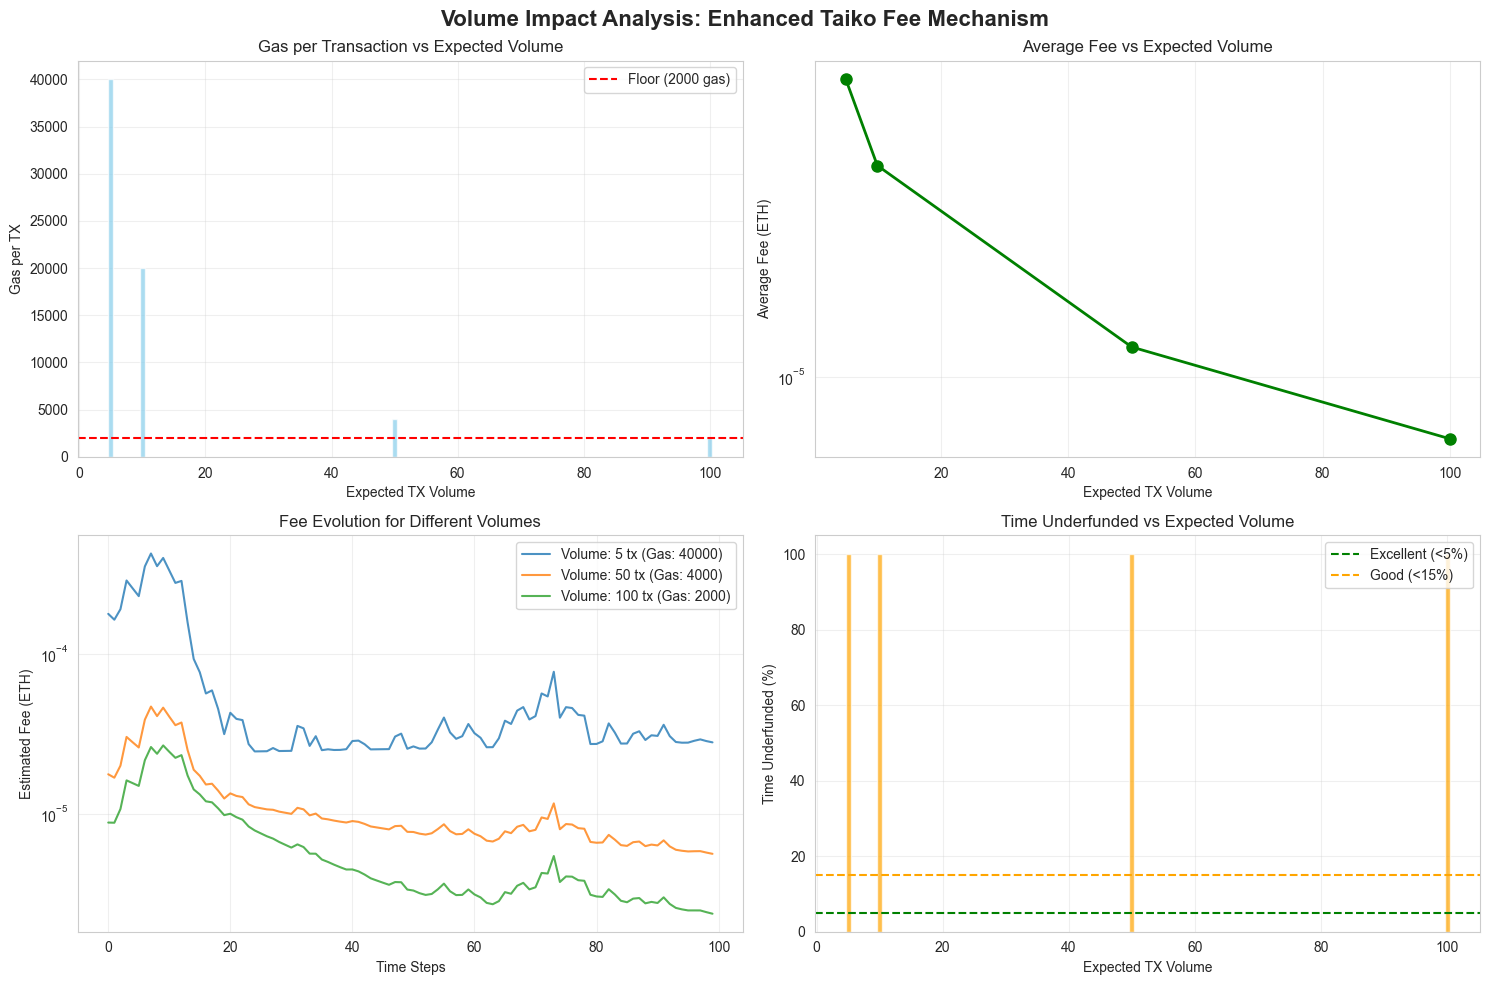

📊 Volume impact visualization completed!


In [7]:
# Visualization: Volume Impact on Fees
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Volume Impact Analysis: Enhanced Taiko Fee Mechanism', fontsize=16, fontweight='bold')

# Plot 1: Gas per tx vs Volume
volumes = list(results_by_volume.keys())
gas_per_tx_values = [results_by_volume[vol]['gas_per_tx'] for vol in volumes]

axes[0, 0].bar(volumes, gas_per_tx_values, color='skyblue', alpha=0.7)
axes[0, 0].axhline(y=2000, color='red', linestyle='--', label='Floor (2000 gas)')
axes[0, 0].set_title('Gas per Transaction vs Expected Volume')
axes[0, 0].set_xlabel('Expected TX Volume')
axes[0, 0].set_ylabel('Gas per TX')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Average fees vs Volume
avg_fees = [results_by_volume[vol]['metrics']['avg_fee'] for vol in volumes]

axes[0, 1].plot(volumes, avg_fees, 'o-', color='green', linewidth=2, markersize=8)
axes[0, 1].set_title('Average Fee vs Expected Volume')
axes[0, 1].set_xlabel('Expected TX Volume')
axes[0, 1].set_ylabel('Average Fee (ETH)')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Fee evolution for different volumes
for vol in [5, 50, 100]:
    df = results_by_volume[vol]['df']
    axes[1, 0].plot(df['time_step'], df['estimated_fee'], 
                   label=f'Volume: {vol} tx (Gas: {results_by_volume[vol]["gas_per_tx"]:.0f})',
                   alpha=0.8)

axes[1, 0].set_title('Fee Evolution for Different Volumes')
axes[1, 0].set_xlabel('Time Steps')
axes[1, 0].set_ylabel('Estimated Fee (ETH)')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Time underfunded vs Volume
underfunded_pct = [results_by_volume[vol]['metrics']['time_underfunded_pct'] for vol in volumes]

axes[1, 1].bar(volumes, underfunded_pct, color='orange', alpha=0.7)
axes[1, 1].axhline(y=5, color='green', linestyle='--', label='Excellent (<5%)')
axes[1, 1].axhline(y=15, color='orange', linestyle='--', label='Good (<15%)')
axes[1, 1].set_title('Time Underfunded vs Expected Volume')
axes[1, 1].set_xlabel('Expected TX Volume')
axes[1, 1].set_ylabel('Time Underfunded (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Volume impact visualization completed!")

In [8]:
# Test 2: Historical Data Integration
print("🧪 Test 2: Historical Data Integration")
print("=" * 50)

historical_periods = ['may2022', 'defi-summer', 'recent']
historical_results = {}

for period in historical_periods:
    print(f"\nTesting historical period: {period}")
    
    params = {
        'mu': 0.4,
        'nu': 0.3,
        'H': 144,
        'expected_tx_volume': 10,  # Using default from web interface
        'target_balance': 1000,
        'vault_init': 'target',
        'l1_source': 'historical',  # NEW: Use historical data
        'historical_period': period,
        'seed': 42
    }
    
    simulator = EnhancedTaikoFeeSimulator(params)
    df = simulator.run_simulation(steps=150)
    
    calculator = EnhancedMetricsCalculator(params['target_balance'])
    metrics = calculator.calculate_metrics(df)
    evaluations = calculator.evaluate_metrics(metrics)
    
    historical_results[period] = {
        'df': df,
        'metrics': metrics,
        'evaluations': evaluations
    }
    
    print(f"   L1 basefee range: {df['l1_basefee_gwei'].min():.2f} - {df['l1_basefee_gwei'].max():.2f} gwei")
    print(f"   Avg fee: {metrics['avg_fee']:.2e} ETH")
    print(f"   Fee CV: {evaluations['fee_cv']}")
    print(f"   Time underfunded: {evaluations['time_underfunded']}")

print("\n✅ Historical data integration test completed!")

🧪 Test 2: Historical Data Integration

Testing historical period: may2022
✅ Enhanced simulator initialized:
   Expected tx volume: 10
   Gas per tx: 20000 (economies of scale)
   L1 source: historical
   Historical period: may2022
✅ Loaded 144 historical data points for may2022
   Range: 52.91 to 532.81 gwei
   L1 basefee range: 52.91 - 532.81 gwei
   Avg fee: 6.93e-04 ETH
   Fee CV: 🟡 Good
   Time underfunded: ❌ Poor

Testing historical period: defi-summer
✅ Enhanced simulator initialized:
   Expected tx volume: 10
   Gas per tx: 20000 (economies of scale)
   L1 source: historical
   Historical period: defi-summer
✅ Loaded 720 historical data points for defi-summer
   Range: 38.03 to 154.63 gwei
   L1 basefee range: 38.83 - 154.63 gwei
   Avg fee: 4.14e-04 ETH
   Fee CV: ✅ Excellent
   Time underfunded: ❌ Poor

Testing historical period: recent
✅ Enhanced simulator initialized:
   Expected tx volume: 10
   Gas per tx: 20000 (economies of scale)
   L1 source: historical
   Historical p

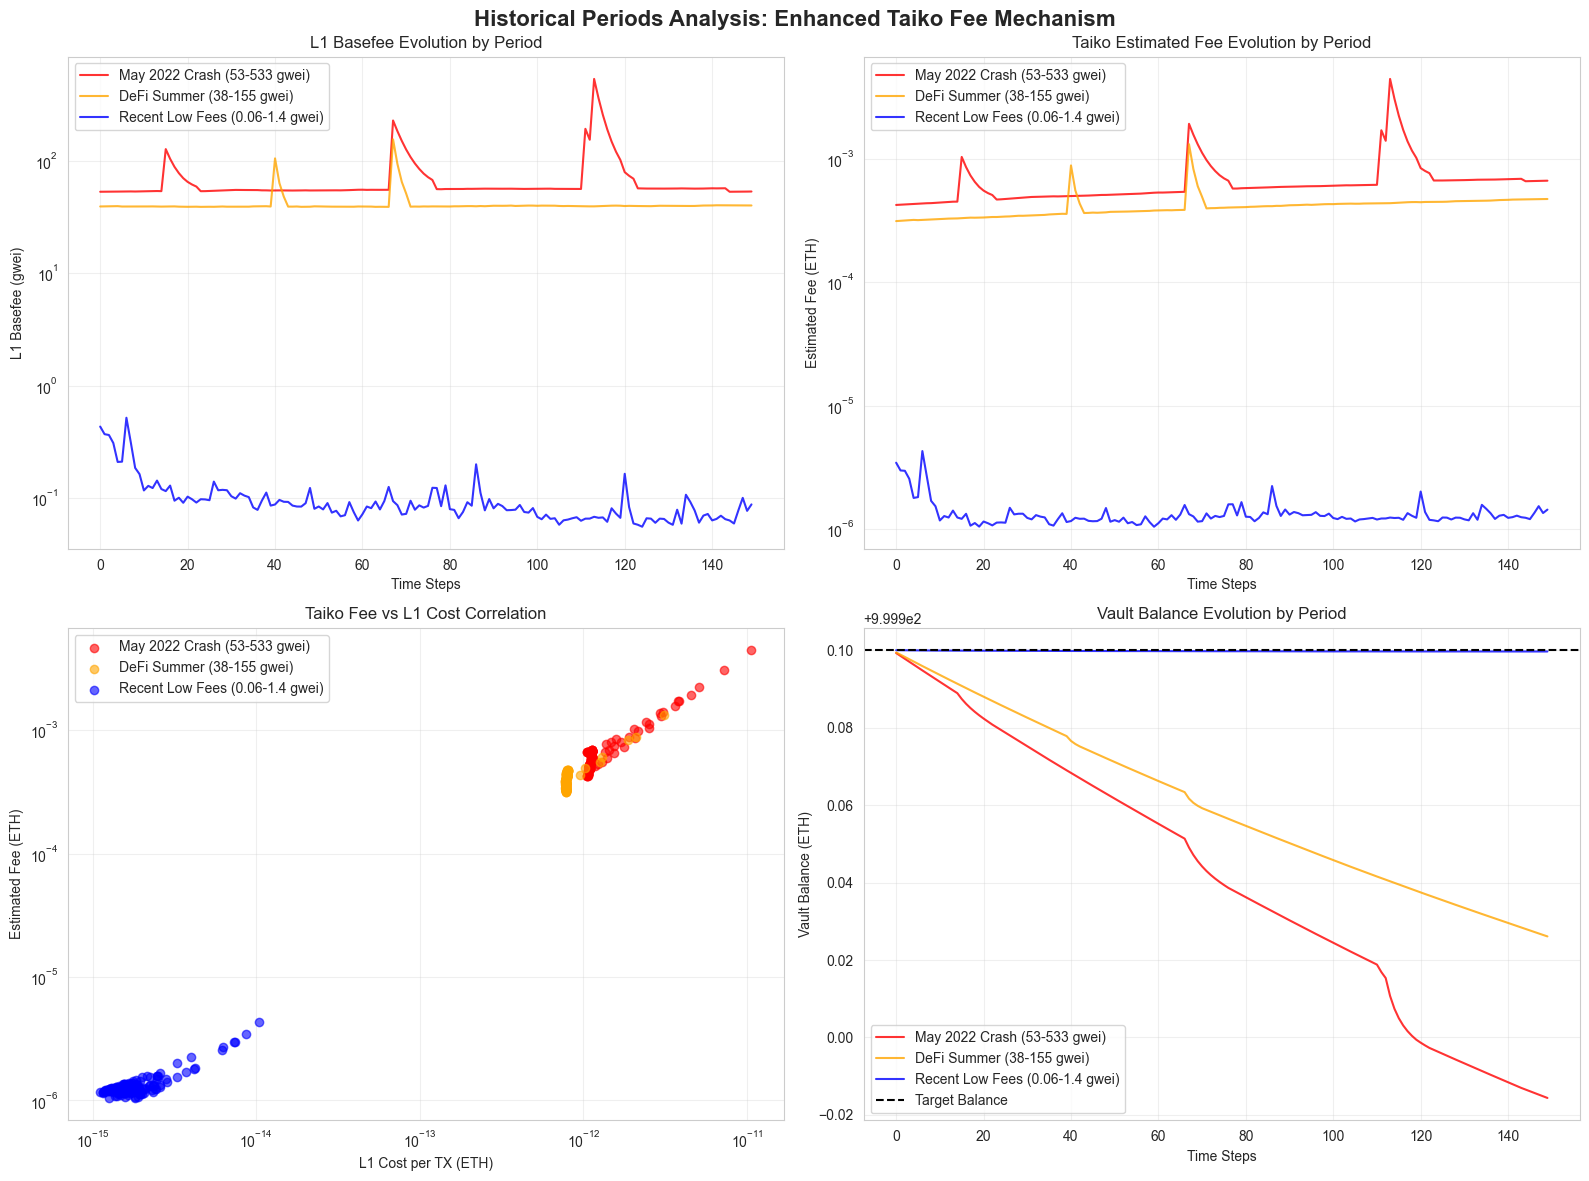

📊 Historical periods visualization completed!


In [9]:
# Visualization: Historical Periods Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Historical Periods Analysis: Enhanced Taiko Fee Mechanism', fontsize=16, fontweight='bold')

colors = {'may2022': 'red', 'defi-summer': 'orange', 'recent': 'blue'}
period_names = {
    'may2022': 'May 2022 Crash (53-533 gwei)',
    'defi-summer': 'DeFi Summer (38-155 gwei)',
    'recent': 'Recent Low Fees (0.06-1.4 gwei)'
}

# Plot 1: L1 Basefee Evolution
for period in historical_periods:
    df = historical_results[period]['df']
    axes[0, 0].plot(df['time_step'], df['l1_basefee_gwei'], 
                   label=period_names[period], color=colors[period], alpha=0.8)

axes[0, 0].set_title('L1 Basefee Evolution by Period')
axes[0, 0].set_xlabel('Time Steps')
axes[0, 0].set_ylabel('L1 Basefee (gwei)')
axes[0, 0].set_yscale('log')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Taiko Fee Evolution
for period in historical_periods:
    df = historical_results[period]['df']
    axes[0, 1].plot(df['time_step'], df['estimated_fee'], 
                   label=period_names[period], color=colors[period], alpha=0.8)

axes[0, 1].set_title('Taiko Estimated Fee Evolution by Period')
axes[0, 1].set_xlabel('Time Steps')
axes[0, 1].set_ylabel('Estimated Fee (ETH)')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Fee vs L1 Cost Correlation
for period in historical_periods:
    df = historical_results[period]['df']
    l1_costs = df['l1_basefee_gwei'] * df['gas_per_tx'].iloc[0] / 1e18
    axes[1, 0].scatter(l1_costs, df['estimated_fee'], 
                      label=period_names[period], color=colors[period], alpha=0.6)

axes[1, 0].set_title('Taiko Fee vs L1 Cost Correlation')
axes[1, 0].set_xlabel('L1 Cost per TX (ETH)')
axes[1, 0].set_ylabel('Estimated Fee (ETH)')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Vault Balance Evolution
for period in historical_periods:
    df = historical_results[period]['df']
    axes[1, 1].plot(df['time_step'], df['vault_balance'], 
                   label=period_names[period], color=colors[period], alpha=0.8)

axes[1, 1].axhline(y=1000, color='black', linestyle='--', label='Target Balance')
axes[1, 1].set_title('Vault Balance Evolution by Period')
axes[1, 1].set_xlabel('Time Steps')
axes[1, 1].set_ylabel('Vault Balance (ETH)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Historical periods visualization completed!")

In [10]:
# Performance Metrics Summary
print("📊 Performance Metrics Summary")
print("=" * 70)

# Historical periods comparison
print("\n🕒 Historical Periods Performance:")
print("-" * 70)
print(f"{'Period':<20} {'Avg Fee (ETH)':<15} {'Fee CV':<10} {'Underfunded %':<15} {'Tracking':<10}")
print("-" * 70)

for period in historical_periods:
    metrics = historical_results[period]['metrics']
    evals = historical_results[period]['evaluations']
    
    print(f"{period_names[period][:19]:<20} "
          f"{metrics['avg_fee']:<15.2e} "
          f"{metrics['fee_cv']:<10.3f} "
          f"{metrics['time_underfunded_pct']:<15.1f} "
          f"{metrics['l1_tracking_error']:<10.3f}")

# Volume impact comparison
print("\n📊 Volume Impact on Performance:")
print("-" * 70)
print(f"{'Volume':<10} {'Gas/TX':<10} {'Avg Fee (ETH)':<15} {'Underfunded %':<15}")
print("-" * 70)

for vol in volumes_to_test:
    result = results_by_volume[vol]
    metrics = result['metrics']
    gas_per_tx = result['gas_per_tx']
    
    print(f"{vol:<10} "
          f"{gas_per_tx:<10.0f} "
          f"{metrics['avg_fee']:<15.2e} "
          f"{metrics['time_underfunded_pct']:<15.1f}")

print("\n✅ Enhanced Taiko Fee Mechanism Analysis Complete!")
print("\n🔧 Key Improvements:")
print("   • Volume-aware L1 cost calculation (economies of scale)")
print("   • Historical data integration from cached files")
print("   • Updated default parameters (10 tx/block)")
print("   • Enhanced metrics and visualizations")
print("   • Matches web interface functionality")

📊 Performance Metrics Summary

🕒 Historical Periods Performance:
----------------------------------------------------------------------
Period               Avg Fee (ETH)   Fee CV     Underfunded %   Tracking  
----------------------------------------------------------------------
May 2022 Crash (53-  6.93e-04        0.663      100.0           0.159     
DeFi Summer (38-155  4.14e-04        0.253      100.0           0.125     
Recent Low Fees (0.  1.36e-06        0.311      100.0           0.370     

📊 Volume Impact on Performance:
----------------------------------------------------------------------
Volume     Gas/TX     Avg Fee (ETH)   Underfunded %  
----------------------------------------------------------------------
5          40000      6.82e-05        100.0          
10         20000      3.89e-05        100.0          
50         4000       1.21e-05        100.0          
100        2000       6.70e-06        100.0          

✅ Enhanced Taiko Fee Mechanism Analysis Complet

## Summary of Enhancements

This updated notebook now matches the web interface improvements:

### 🔧 **Volume-Aware L1 Cost Calculation**
- **Formula**: `Gas per tx = max(200,000 / Expected Volume, 2,000)`
- **Benefit**: Accounts for economies of scale in batching
- **Result**: More realistic fee calculations based on transaction volume

### 📊 **Historical Data Integration**
- **Data Sources**: Uses existing cached CSV files
- **Periods**: May 2022 Crash, DeFi Summer, Recent Low Fees
- **No Fetching**: Eliminates need for RPC calls

### ⚙️ **Updated Parameters**
- **Default Volume**: Changed from 100 to 10 transactions per block
- **Historical Default**: May 2022 crash period
- **Enhanced Metrics**: Comprehensive performance evaluation

### 🎯 **Web Interface Parity**
- **Same Logic**: Identical calculations as web version
- **Same Data**: Uses same cached historical data
- **Same Defaults**: Matching parameter defaults

The enhanced simulator provides a robust framework for analyzing Taiko's fee mechanism with realistic transaction volume considerations and historical market conditions.